In [85]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

In [86]:
df = pd.read_csv('../input/amazon-data-science-book-reviews/reviews.csv')
df.head()

,stars,comment,book_url
0,5.0,"Let me say at the outset of this review, that ...",https://www.amazon.com/dp/1492041130
1,1.0,Its Capitalism at its best. I read the book fr...,https://www.amazon.com/dp/1492041130
2,5.0,If you're looking to get started with data sci...,https://www.amazon.com/dp/1492041130
3,4.0,"In general, this is a good book. It covers a w...",https://www.amazon.com/dp/1492041130
4,5.0,I was an academic data scientist decades befor...,https://www.amazon.com/dp/1492041130


# 1. Data Analysis - EDA

In [87]:
df.shape

(20647, 3)

In [88]:
df.isnull().sum()

stars       0
comment     0
book_url    0
dtype: int64

In [89]:
np.sort(df['stars'].unique())

array([1., 2., 3., 4., 5.])

Text(0, 0.5, 'count')

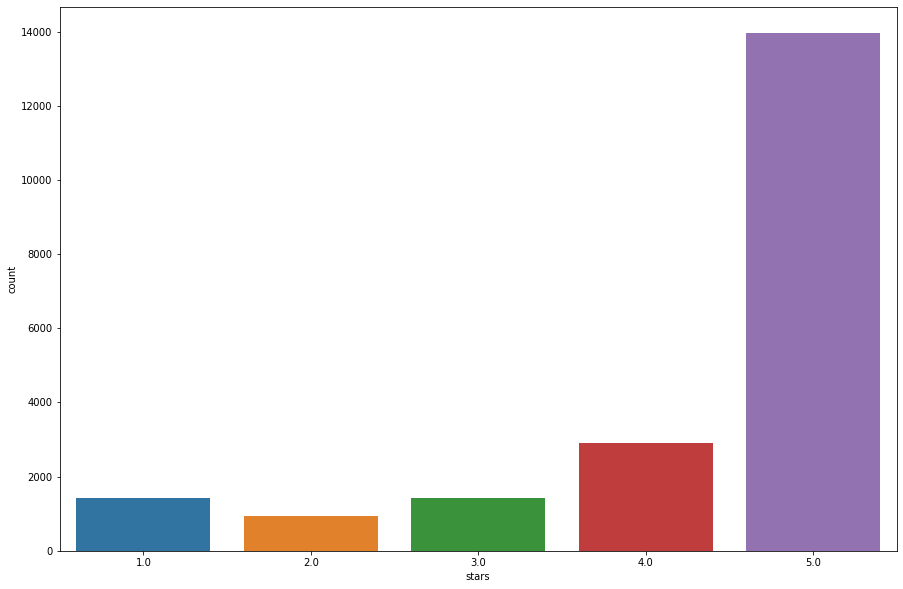

In [90]:
df_grouped = df.groupby(by=['stars']).count()

plt.figure(figsize=(15,10))
ax = sns.barplot(x=df_grouped.index ,y=df_grouped['comment'])
ax.set_ylabel('count')

Most of the reviews have a 5 star rating, what makes our dataset a big unbalanced, but with 20k reviews i think we can have some good results with our classifications attempts 

In [91]:
df[['stars']].describe()

,stars
count,20647.000000
mean,4.309197
std,1.205554
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


# 2. Steming

Here we will apply the stemer on our reviews, to make them more easy to work and extract better results

In [92]:
import nltk
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

#Create the stemmer and apply it on the stop words
stem = SnowballStemmer('english')
stop_words = stopwords.words('english')
stop_words = [stem.stem(word) for word in stop_words]

In [93]:
#Function to apply the steaming process on a specific column from a dataframe 
def stemming_text(df, column_name, stem, language):
    new_column = list()
    for text in df[column_name]:
        token = word_tokenize(text.lower(), language=language)
        new_text = ' '.join([stem.stem(word) for word in token])
        new_column.append(new_text)
    return new_column

In [94]:
df['comment_stem'] = pd.Series(stemming_text(df, 'comment', stem, 'english'), index = df.index)
df.head()

,stars,comment,book_url,comment_stem
0,5.0,"Let me say at the outset of this review, that ...",https://www.amazon.com/dp/1492041130,"let me say at the outset of this review , that..."
1,1.0,Its Capitalism at its best. I read the book fr...,https://www.amazon.com/dp/1492041130,it capit at it best . i read the book from my ...
2,5.0,If you're looking to get started with data sci...,https://www.amazon.com/dp/1492041130,if you re look to get start with data scienc b...
3,4.0,"In general, this is a good book. It covers a w...",https://www.amazon.com/dp/1492041130,"in general , this is a good book . it cover a ..."
4,5.0,I was an academic data scientist decades befor...,https://www.amazon.com/dp/1492041130,i was an academ data scientist decad befor the...


In [95]:
print(df['comment'].iloc[10])
print('-'*50)
print(df['comment_stem'].iloc[10])

I teach intermediate business analytics and this book is a perfect way to introduce people to data science starting from the math.
--------------------------------------------------
i teach intermedi busi analyt and this book is a perfect way to introduc peopl to data scienc start from the math .


Working properly!

# 3. Tfidf Vectorizing

For this first part, we will use the TFidf Vectorizer from sklearn and test the encoding on the classifiers and regressors from sklearn. So this first part will be only using "basic" Machine Learning and no deep learning with keras!

In [96]:
feature = df['comment_stem']
target = df['stars'].astype(int)
target = target - 1

In [97]:
from sklearn.model_selection import train_test_split

# Divide in train an test
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.2, random_state=42, stratify = target)

In [98]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfid = TfidfVectorizer(stop_words = stop_words, max_features = 20000)
tfid.fit(df['comment_stem'])

X_train_tfid = tfid.transform(X_train)
X_test_tdif = tfid.transform(X_test)

In [99]:
# Function to test the classifiers
def test_classifier(X_train, X_test, y_train, y_test, classifier, name_classifier):
    classifier.fit(X_train, y_train)
    score = classifier.score(X_test, y_test)
    print('%s: %.2f%%' %  (name_classifier, (score * 100)))

# 3.1 Classification (With Sklearn)

In [100]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

model = DummyClassifier(strategy='stratified')
test_classifier(X_train_tfid,X_test_tdif, y_train, y_test, model, 'Dummy')

model = LogisticRegression(max_iter = 5000)
test_classifier(X_train_tfid,X_test_tdif, y_train, y_test, model, 'Logistic Regression')

model = DecisionTreeClassifier()
test_classifier(X_train_tfid,X_test_tdif, y_train, y_test, model, 'Decision Tree')

model = KNeighborsClassifier(n_neighbors=7)
test_classifier(X_train_tfid,X_test_tdif, y_train, y_test, model, 'K Neighbors')

model = MultinomialNB()
test_classifier(X_train_tfid,X_test_tdif, y_train, y_test, model, 'Multinomial NB')

Dummy: 49.06%
Logistic Regression: 71.09%
Decision Tree: 61.16%
K Neighbors: 67.72%
Multinomial NB: 67.63%


Well, we had some very interesting results here! The dummy had a decent result even considering that we have 5 classes, but that's probably because of the big number of 5 star reviews we have on our data

The rest of the classifiers had some good results comparing with the dummy, especially Logistic Regression!

# 3.2 Regression (With Sklearn)

In [101]:
feature = df['comment_stem']
target = df['stars']

X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.2, random_state=42)

In [102]:
from sklearn.preprocessing import StandardScaler

scaler_target = StandardScaler()
scaler_target.fit(y_train.values.reshape(-1,1))
y_train_scaled = scaler_target.transform(y_train.values.reshape(-1,1))
y_test_scaled = scaler_target.transform(y_test.values.reshape(-1,1))

In [103]:
X_train_tfid = tfid.transform(X_train)
X_test_tdif = tfid.transform(X_test)

In [104]:
from sklearn.metrics import mean_squared_error

# Function to test the regressors, showing the R squared and mean squared error indicators 
def test_regressor(X_train, X_test, y_train, y_test, regressor, name_regressor):
    model.fit(X_train, y_train)
    score_r = model.score(X_test, y_test)
    
    y_predict = model.predict(X_test)
    score_mean_error = mean_squared_error(y_test, y_predict)
    
    print('%s:' % (name_regressor))
    print('\t R²: %.5f' % (score_r))
    print('\t Mean Squared Error: %.5f' % (score_mean_error))

In [105]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LassoCV

model = DummyRegressor(strategy="mean")
test_regressor(X_train_tfid,X_test_tdif, y_train_scaled.reshape(-1), y_test_scaled.reshape(-1), model, 'Dummy Regressor')
print()

model = SGDRegressor()
test_regressor(X_train_tfid,X_test_tdif, y_train_scaled.reshape(-1), y_test_scaled.reshape(-1), model, 'SGDR')
print()

model = KNeighborsRegressor(n_neighbors = 1000)
test_regressor(X_train_tfid,X_test_tdif, y_train_scaled.reshape(-1), y_test_scaled.reshape(-1), model, 'K Neighbors Regressor')
print()

model = LinearRegression()
test_regressor(X_train_tfid,X_test_tdif, y_train_scaled.reshape(-1), y_test_scaled.reshape(-1), model, 'Linear Regression')
print()

model = DecisionTreeRegressor()
test_regressor(X_train_tfid,X_test_tdif, y_train_scaled.reshape(-1), y_test_scaled.reshape(-1), model, 'Decision Tree Regressor')

Dummy Regressor:
	 R²: -0.00256
	 Mean Squared Error: 1.07445

SGDR:
	 R²: 0.28689
	 Mean Squared Error: 0.76424

K Neighbors Regressor:
	 R²: 0.14661
	 Mean Squared Error: 0.91458

Linear Regression:
	 R²: -7.51792
	 Mean Squared Error: 9.12872

Decision Tree Regressor:
	 R²: -0.22141
	 Mean Squared Error: 1.30899


Here we had some not very good results, with just the SGDR and K Neighbors having a better result than the dummy. I think we gonna stick with the classification in this case

In [106]:
feature = df['comment_stem']
target = df['stars'].astype(int)

# 4. Word Embedding (With Keras)

Here we gonna use a different type of encoding, called word embedding and we will use with it the keras

Most of the code here is based on the work of Nikolai Janakiev and Alexander Chow, so i will link the articles i used for this part. I higly recommend checking them out to better understand the code!

Nikolai Janakiev: https://realpython.com/python-keras-text-classification/#choosing-a-data-set

Alexander Chow: https://medium.com/geekculture/nlp-with-tensorflow-keras-explanation-and-tutorial-cae3554b1290

In [107]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Creating the tokenizer
vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<UNK>')
tokenizer.fit_on_texts(feature)

# Setting the vocab_size
vocab_size = len(tokenizer.word_index) + 1

In [108]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# This function tokenizes the text and add a padding based on the maxlen
def get_sequences(tokenizer, texts, maxlen = 50):
  # making all sequences same length
  sequences = tokenizer.texts_to_sequences(texts)
  padded = pad_sequences(sequences, truncating = 'post', padding='post', maxlen=maxlen)
  return padded

In [109]:
maxlen = 1000
padded_train_seq = get_sequences(tokenizer, feature, maxlen=maxlen)

In [110]:
# Plot a graph comparing the results of the fit of the model based on the accuracy
def print_accuracy(result):
    plt.figure(figsize=(12,8))
    plt.plot(result.history['accuracy'])
    plt.plot(result.history['val_accuracy'])
    plt.legend(['Train', 'Validation'])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [111]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
    print("Training Accuracy: {:.4f}".format(accuracy))
    loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
    print("Testing Accuracy:  {:.4f}".format(accuracy))

## 4.1 First Solution

This first solution is based on the code of Alexander Chow that i linked before

We will use TPU to make the process faster, if you don't want to use it, just take out the part related to the TPU of the code

In [112]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# instantiating the model in the strategy scope creates the model on the TPU
with tpu_strategy.scope():
    # -------------- TPU ---------------- If you don't want to use it, just use this part below
    model = tf.keras.models.Sequential([
                                        tf.keras.layers.Embedding(10000,50,input_length=maxlen, trainable=True),
                                        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
                                        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
                                        tf.keras.layers.Dense(5, activation='softmax')
    ])
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

2022-08-27 22:13:23.582738: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-08-27 22:13:23.583014: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30020}
2022-08-27 22:13:23.585659: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-08-27 22:13:23.585702: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30020}


In [113]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 1000, 50)          500000    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 1000, 40)          11360     
_________________________________________________________________
bidirectional_7 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 205       
Total params: 521,325
Trainable params: 521,325
Non-trainable params: 0
_________________________________________________________________


In [114]:
feature_sequence = get_sequences(tokenizer, feature)
target_normalized = target - 1

# Divide in train an test
X_train, X_test, y_train, y_test = train_test_split(feature_sequence, target_normalized, test_size=0.2, random_state=42, stratify = target_normalized)

In [115]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
)

Epoch 1/20
517/517 [==============================] - 23s 28ms/step - loss: 1.0482 - accuracy: 0.6756 - val_loss: 0.8281 - val_accuracy: 0.6990
Epoch 2/20
517/517 [==============================] - 10s 20ms/step - loss: 0.7798 - accuracy: 0.7121 - val_loss: 0.7993 - val_accuracy: 0.7087
Epoch 3/20
517/517 [==============================] - 10s 20ms/step - loss: 0.6957 - accuracy: 0.7395 - val_loss: 0.7919 - val_accuracy: 0.7039
Epoch 4/20
517/517 [==============================] - 10s 20ms/step - loss: 0.6067 - accuracy: 0.7685 - val_loss: 0.8254 - val_accuracy: 0.6995


In [116]:
evaluate_model(model, X_train, X_test, y_train, y_test)

Training Accuracy: 0.8171
Testing Accuracy:  0.6995


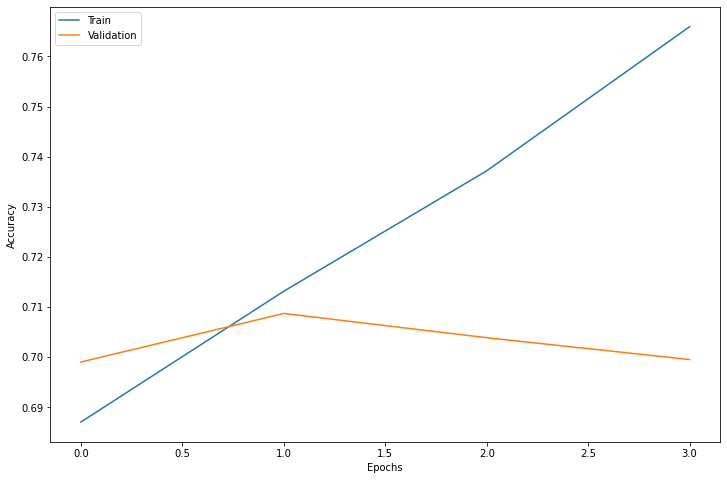

In [117]:
print_accuracy(history)

## 4.2 Second Solution

The second and third solutions are based on the code of Nikolai Janakiev linked before

In [118]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

embedding_dim = 50


# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# instantiating the model in the strategy scope creates the model on the TPU
with tpu_strategy.scope():
    model = Sequential()
    model.add(layers.Embedding(input_dim=vocab_size, 
                               output_dim=embedding_dim, 
                               input_length=maxlen))
    model.add(layers.GlobalMaxPool1D())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(5, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
model.summary()

2022-08-27 22:14:30.272635: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-08-27 22:14:30.272716: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30020}
2022-08-27 22:14:30.275401: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-08-27 22:14:30.275486: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30020}


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 1000, 50)          1360550   
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 50)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                3264      
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 325       
Total params: 1,364,139
Trainable params: 1,364,139
Non-trainable params: 0
_________________________________________________________________


In [119]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    validation_data=(X_test, y_test),
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/20
517/517 [==============================] - 14s 21ms/step - loss: 1.1522 - accuracy: 0.6658 - val_loss: 0.9156 - val_accuracy: 0.6765
Epoch 2/20
517/517 [==============================] - 8s 16ms/step - loss: 0.8713 - accuracy: 0.6839 - val_loss: 0.8476 - val_accuracy: 0.6959
Epoch 3/20
517/517 [==============================] - 8s 16ms/step - loss: 0.7782 - accuracy: 0.7060 - val_loss: 0.8233 - val_accuracy: 0.7015
Epoch 4/20
517/517 [==============================] - 9s 17ms/step - loss: 0.6989 - accuracy: 0.7302 - val_loss: 0.8252 - val_accuracy: 0.6976
Epoch 5/20
517/517 [==============================] - 9s 17ms/step - loss: 0.6246 - accuracy: 0.7599 - val_loss: 0.8466 - val_accuracy: 0.6947


In [120]:
evaluate_model(model, X_train, X_test, y_train, y_test)

Training Accuracy: 0.7993
Testing Accuracy:  0.6947


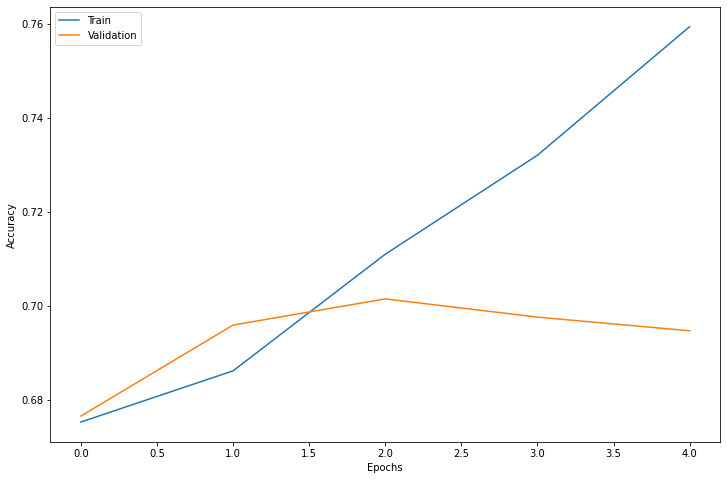

In [121]:
print_accuracy(history)

## 4.3 Third Solution (With CNN)

In [122]:
embedding_dim = 100

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

embedding_dim = 50


# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# instantiating the model in the strategy scope creates the model on the TPU
with tpu_strategy.scope():
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(128, 5, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(5, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
model.summary()

2022-08-27 22:15:32.928655: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-08-27 22:15:32.928728: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30020}
2022-08-27 22:15:32.931190: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-08-27 22:15:32.931277: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30020}


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 1000, 50)          1360550   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 996, 128)          32128     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 55        
Total params: 1,394,023
Trainable params: 1,394,023
Non-trainable params: 0
_________________________________________________________________


In [123]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    validation_data=(X_test, y_test),
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/20
517/517 [==============================] - 14s 21ms/step - loss: 1.1982 - accuracy: 0.6180 - val_loss: 0.8584 - val_accuracy: 0.6867
Epoch 2/20
517/517 [==============================] - 8s 16ms/step - loss: 0.8085 - accuracy: 0.7000 - val_loss: 0.8093 - val_accuracy: 0.7036
Epoch 3/20
517/517 [==============================] - 8s 16ms/step - loss: 0.6737 - accuracy: 0.7368 - val_loss: 0.8135 - val_accuracy: 0.7070
Epoch 4/20
517/517 [==============================] - 9s 16ms/step - loss: 0.5555 - accuracy: 0.7920 - val_loss: 0.8687 - val_accuracy: 0.6973
Epoch 5/20
517/517 [==============================] - 8s 16ms/step - loss: 0.4315 - accuracy: 0.8441 - val_loss: 0.9683 - val_accuracy: 0.7005


In [124]:
evaluate_model(model, X_train, X_test, y_train, y_test)

Training Accuracy: 0.8862
Testing Accuracy:  0.7005


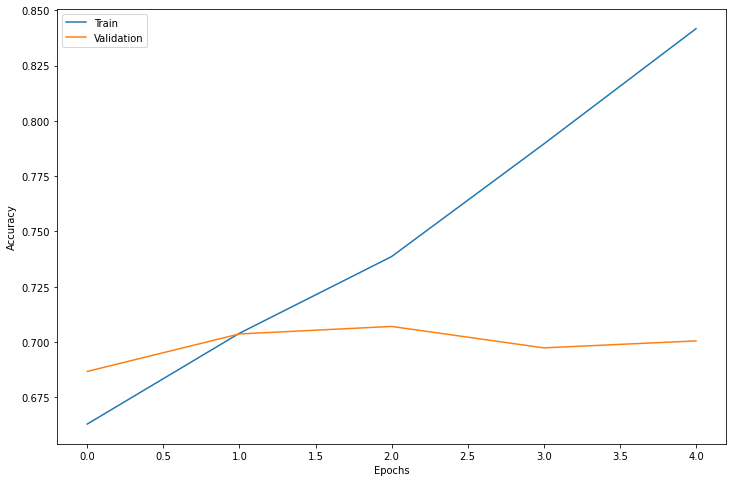

In [125]:
print_accuracy(history)

Well, all the results with keras were good, but still below the Logist Regression from before. This is probably because i didn't any optmization of the models to extract the most of the Neural Networks, but i this serves as a base to start on NLP with keras!

Hope you liked my notebook, and as always, any suggestions, tips, ideas, i'm always open for them!